# Import

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("/kaggle/src")

from model_evaluation_utils import process_oof_prediction, plot_confusion_matrix, plot_importance, plot_learning_curve

# Single model evaluation

# exp010

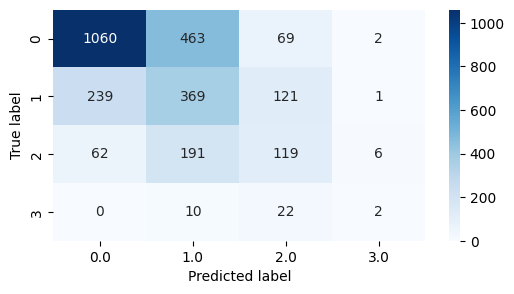

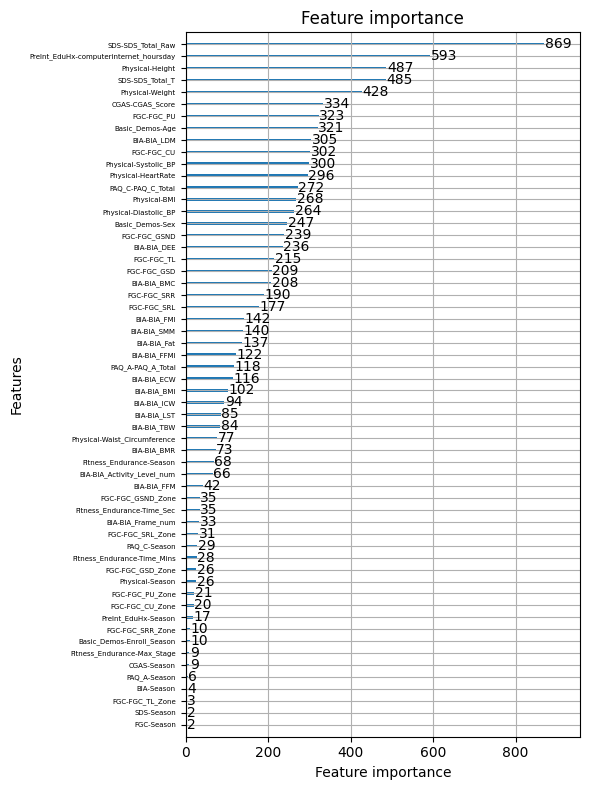

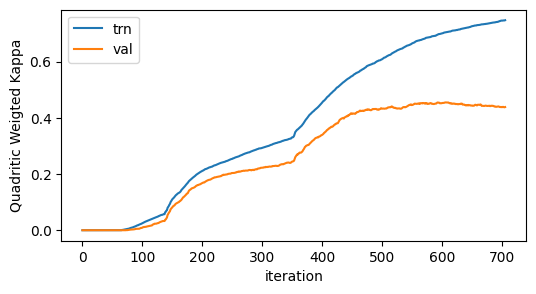

In [33]:
oof_preds_010 = process_oof_prediction("exp010")
plot_confusion_matrix(oof_preds_010)
plot_importance("exp010", 6, 8)
plot_learning_curve("exp010")

# exp011

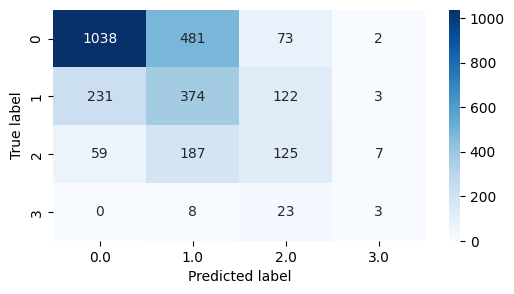

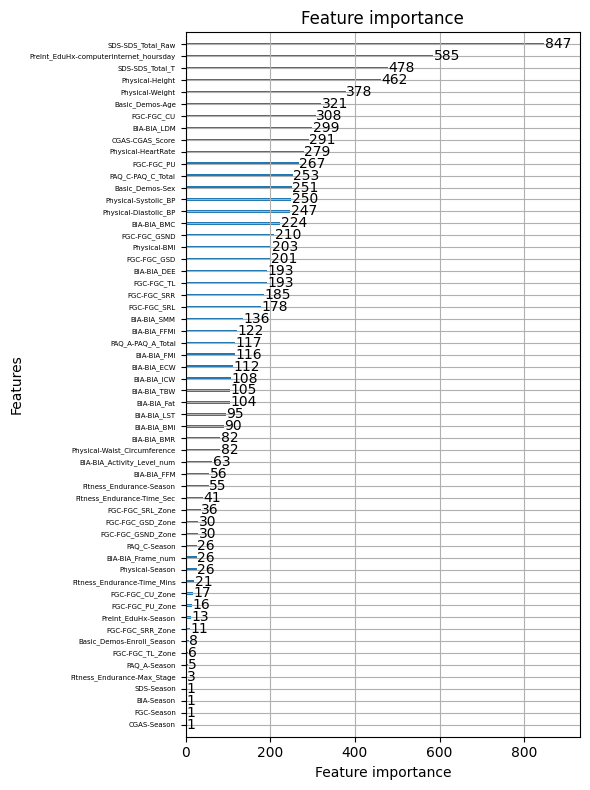

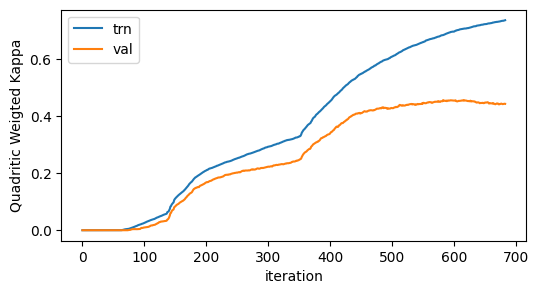

In [32]:
oof_preds_010 = process_oof_prediction("exp011")
plot_confusion_matrix(oof_preds_010)
plot_importance("exp011", 6, 8)
plot_learning_curve("exp011")

# exp012

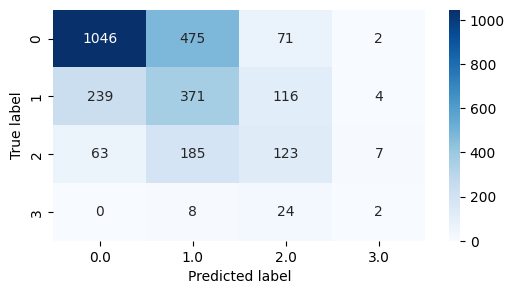

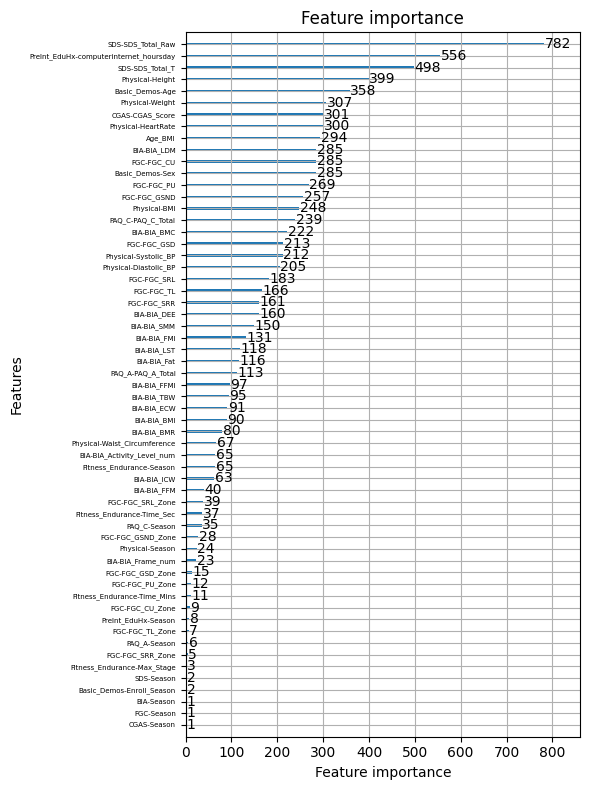

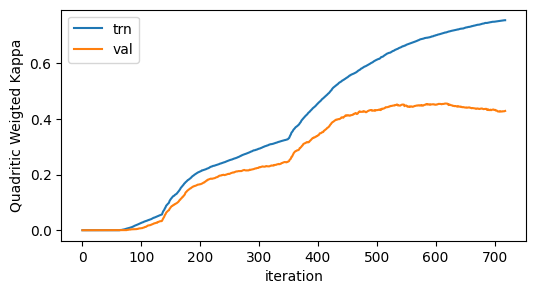

In [6]:
oof_preds_010 = process_oof_prediction("exp012")
plot_confusion_matrix(oof_preds_010)
plot_importance("exp012", 6, 8)
plot_learning_curve("exp012")